In [5]:
import tensorflow as tf
from keras.datasets import mnist
import cv2
import os
import pathlib
from keras.layers import Conv2D, Conv2DTranspose, Dropout, Dense, Reshape, LayerNormalization, LeakyReLU
from keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import f1_score, recall_score, precision_score

In [6]:
class ReadDataset:
    def __init__(self, datasetpath, labels, image_shape):
        self.datasetpath = datasetpath
        self.labels = labels
        self.image_shape = image_shape
    def returListImages(self,):
        self.images = []
        for label in self.labels:
            self.images.append(list(pathlib.Path(os.path.join(self.datasetpath,
                                                              label)).glob('*.*')))
    def readImages(self,):
        self.returListImages()
        self.finalImages = []
        labels = []
        for label in range(len(self.labels)):
            for img in self.images[label]:
                img = cv2.imread(str(img))
                img = cv2.resize(img , self.image_shape)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img  = img/255
                self.finalImages.append(img)
                labels.append(label)
        images = np.array(self.finalImages)
        labels = np.array(labels)
        return images, labels

In [3]:
readDatasetObject = ReadDataset('/kaggle/input/chest-xray-pneumonia/chest_xray/train',
                               ['NORMAL', 'PNEUMONIA'],
                               (64, 64))
images, labels = readDatasetObject.readImages()

In [4]:
images.shape, labels.shape

((5216, 64, 64, 3), (5216,))

Sample images included in the dataset for each class

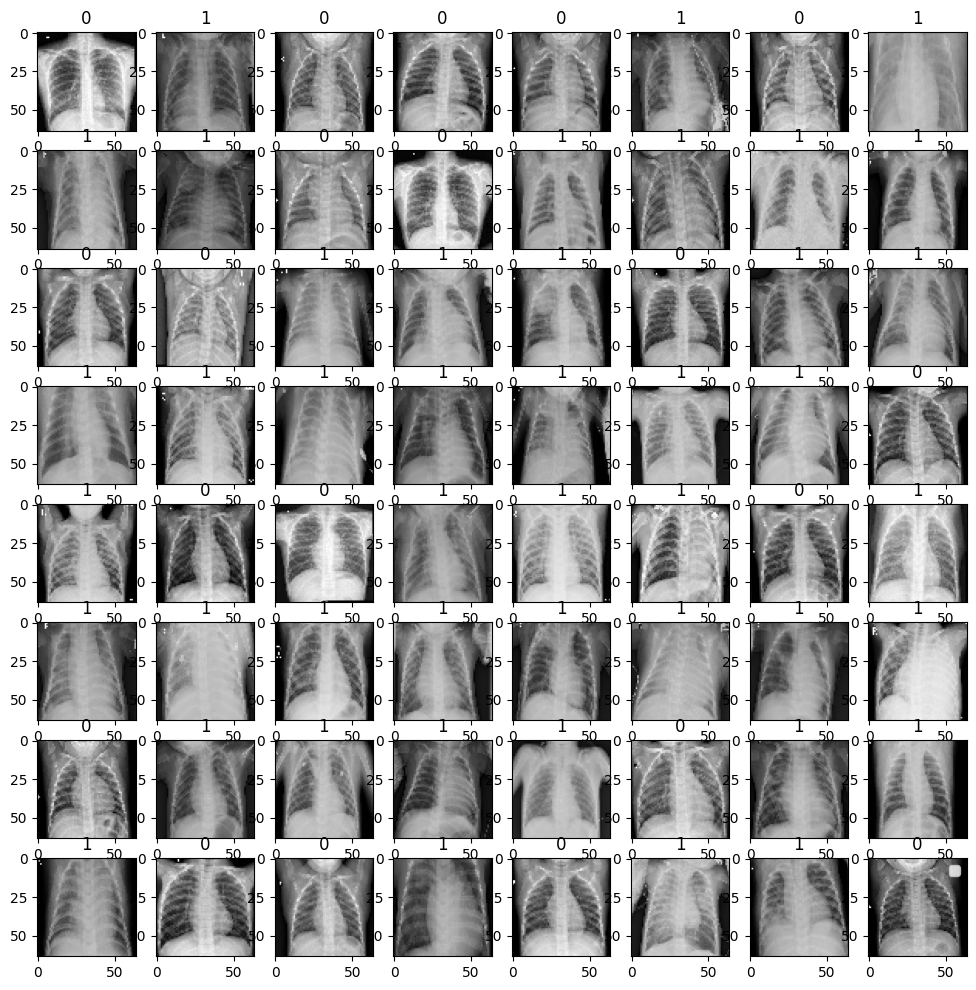

In [8]:
plt.figure(figsize = (12, 12))
indexs = np.random.randint(0, len(labels), size = (64, ))
for i in range(64):
    plt.subplot(8, 8, (i + 1))
    plt.imshow(images[indexs[i]])
    plt.title(labels[indexs[i]])
plt.legend()

In [9]:
class Acgan:
    def __init__(self, eta, batch_size, epochs, weight_decay, latent_space,
                 image_shape, kernel_size):
        self.eta = eta
        self.batch_size = batch_size
        self.epochs = epochs
        self.weight_decay = weight_decay
        self.latent_space = latent_space
        self.image_shape = image_shape
        self.kernel_size = kernel_size
    def data(self, images, labels):
        ytrain = tf.keras.utils.to_categorical(labels)
        self.images = images
        self.labels = ytrain
    def samples(self, G, noize, labels):
        images = G.predict([noize, labels])
        ys = np.argmax(labels, axis = 1)
        plt.figure(figsize = (12, 4))
        for i in range(16):
            plt.subplot(2, 8, (i + 1))
            plt.imshow(images[i], cmap = 'gray')
            plt.title(ys[i])
        plt.show()
    def generator(self, inputs, labels):
        filters = [256, 128, 64, 32]
        padding = 'same'
        x = inputs
        y = labels
        x = layers.concatenate([x, y])
        x = layers.Dense(1024, )(x)
        x = layers.Dense(8*8*filters[0],
                         kernel_regularizer = tf.keras.regularizers.L2(0.001))(x)
        x = layers.Reshape((8, 8, filters[0]))(x)
        for filter in filters:
            if filter >= 64:
                strides = 2
            else:
                strides = 1
            x = LayerNormalization()(x)
            x = layers.Activation('relu')(x)
            x = Conv2DTranspose(filter, kernel_size = self.kernel_size, padding = padding,
                      strides = strides)(x)
        x = Conv2DTranspose(3, kernel_size = self.kernel_size, padding = padding)(x)
        x = layers.Activation('sigmoid')(x)
        self.generatorModel = models.Model(inputs = [inputs, labels],
                                           outputs = x,
                                           name = 'generator')
    def discriminator(self, inputs):
        x = inputs
        filters = [32, 64, 128, 256]
        padding = 'same'
        for filter in filters:
            if filter < 256:
                strides = 2
            else:
                strides = 1
            x = Conv2D(filter, kernel_size = self.kernel_size, padding = padding,
                      strides = strides,
                      kernel_regularizer = tf.keras.regularizers.L2(0.001))(x)
            x = LeakyReLU(alpha = 0.2)(x)
        x = layers.Flatten()(x)
        outputs = Dense(1, )(x)
        labelsOutput = Dense(256,
                             kernel_regularizer = tf.keras.regularizers.L2(0.001))(x)
        labelsOutput = Dropout(0.3)(labelsOutput)
        labelsOutput = Dense(2,)(labelsOutput)
        labelsOutput = layers.Activation('softmax')(labelsOutput)
        self.discriminatorModel = models.Model(inputs = inputs,
                                               outputs = [outputs, labelsOutput],
                                               name = 'discriminator')
    def build(self,):
        generatorInput = layers.Input(shape = (self.latent_space))
        discriminatorInput = layers.Input(shape = (self.image_shape))
        labelsInput = layers.Input(shape = (2, ))
        self.generator(generatorInput, labelsInput)
        self.discriminator(discriminatorInput)
        G = self.generatorModel
        D = self.discriminatorModel
        D.compile(loss = ['mse', 'binary_crossentropy'],
                 optimizer = tf.keras.optimizers.RMSprop(learning_rate = self.eta,
                                                        weight_decay = self.weight_decay))
        D.summary()
        G.summary()
        D.trainable = False
        GAN = models.Model(inputs = [generatorInput, labelsInput],
                           outputs = D(G([generatorInput, labelsInput])))
        GAN.compile(loss = ['mse', 'binary_crossentropy'],
                   optimizer = tf.keras.optimizers.RMSprop(learning_rate = self.eta*0.5,
                                                          weight_decay = self.weight_decay*0.5))
        GAN.summary()
        return G, D, GAN
    def trainAlgorithm(self, G, D, GAN):
        for epoch in range(self.epochs):
            indexs = np.random.randint(0, len(self.images), size = (self.batch_size, ))
            realImages = self.images[indexs]
            realLabels = self.labels[indexs]
            realTag = tf.ones(shape = (self.batch_size, ))
            noize = tf.random.uniform(shape = (self.batch_size,
                                              self.latent_space), minval = -1,
                                     maxval = 1)
            fakeLabels = tf.keras.utils.to_categorical(np.random.choice(range(2), size = (self.batch_size)),
                                                      num_classes = 2)
            fakeImages = tf.squeeze(G.predict([noize, fakeLabels], verbose = 0))
            fakeTag = tf.zeros(shape = (self.batch_size, ))
            allImages = np.vstack([realImages, fakeImages])
            allLabels = np.vstack([realLabels, fakeLabels])
            allTags = np.hstack([realTag, fakeTag])
            _, dlossTag, dlossLabels = D.train_on_batch(allImages, [allTags, allLabels])
            noize = tf.random.uniform(shape = (self.batch_size,
                                              self.latent_space), minval = -1,
                                     maxval = 1)
            _, glossTag, glossLabels = GAN.train_on_batch([noize, fakeLabels], [realTag, fakeLabels])
            if epoch % 5000 == 0:
                print('Epoch: {}'.format(epoch))
                print('discriminator loss: [tag: {}, labels: {}], generator loss: [tag: {}, labels: {}]'.format(dlossTag,
                                                                                                                dlossLabels,
                                                                                                                glossTag,
                                                                                                                glossLabels))
                self.samples(G, noize, fakeLabels)

In [10]:
acgan = Acgan(eta = 0.0001, batch_size = 32, epochs = 32000, weight_decay = 6e-9,
              latent_space = 100, image_shape = (64, 64, 3), kernel_size = 5)

In [11]:
acgan.data(images, labels)

In [12]:
G, D, GAN = acgan.build()

Model: "discriminator"

__________________________________________________________________________________________________

 Layer (type)                   Output Shape         Param #     Connected to                     


 input_2 (InputLayer)           [(None, 64, 64, 3)]  0           []                               

                                                                                                  

 conv2d (Conv2D)                (None, 32, 32, 32)   2432        ['input_2[0][0]']                

                                                                                                  

 leaky_re_lu (LeakyReLU)        (None, 32, 32, 32)   0           ['conv2d[0][0]']                 

                                                                                                  

 conv2d_1 (Conv2D)              (None, 16, 16, 64)   51264       ['leaky_re_lu[0][0]']            

                                                                           

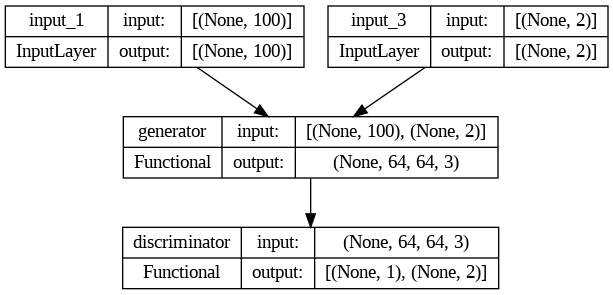

In [13]:
tf.keras.utils.plot_model(GAN, show_shapes = True)

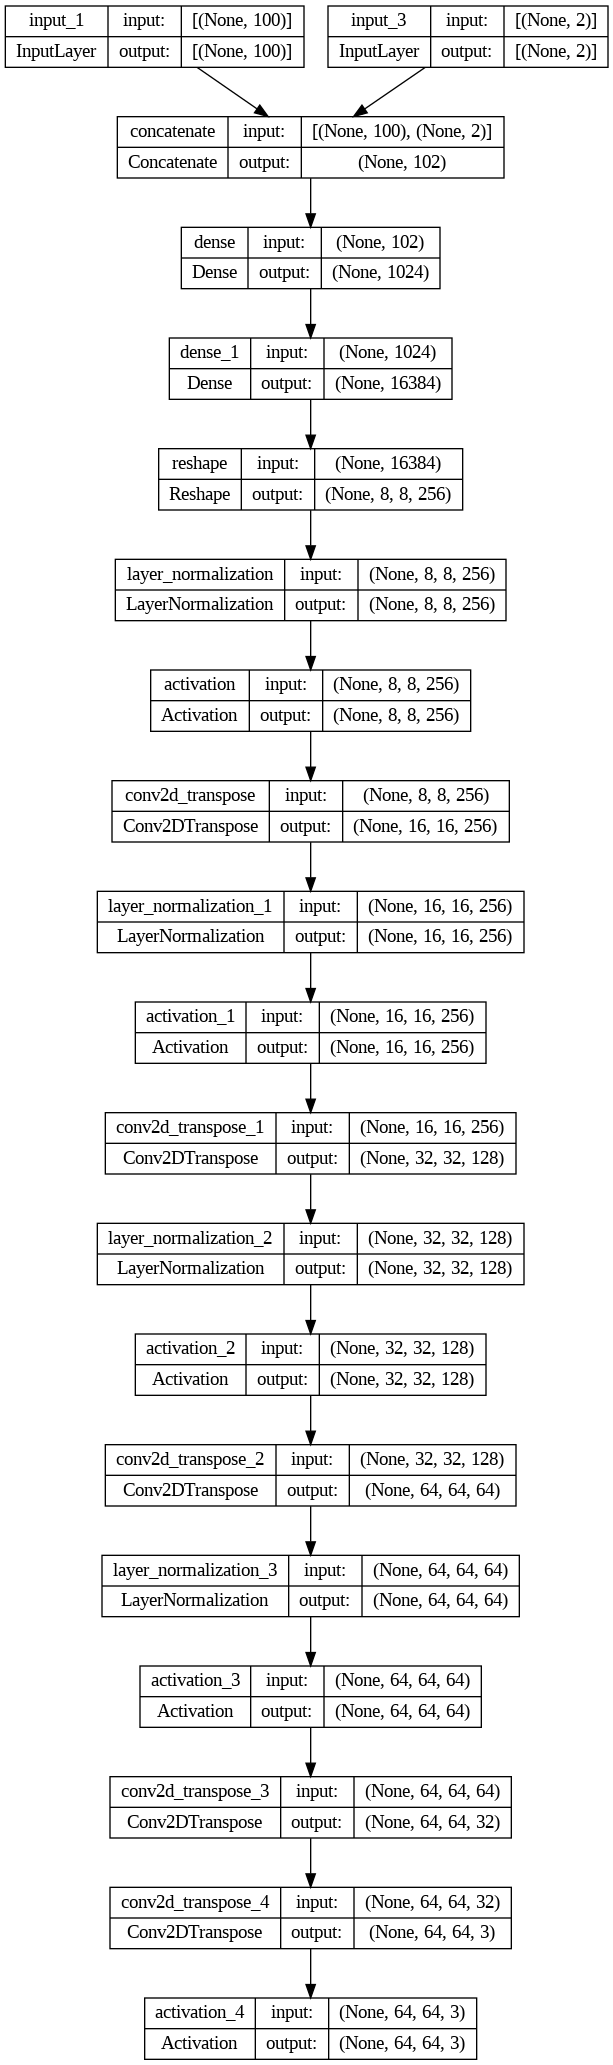

In [14]:
tf.keras.utils.plot_model(G, show_shapes = True)

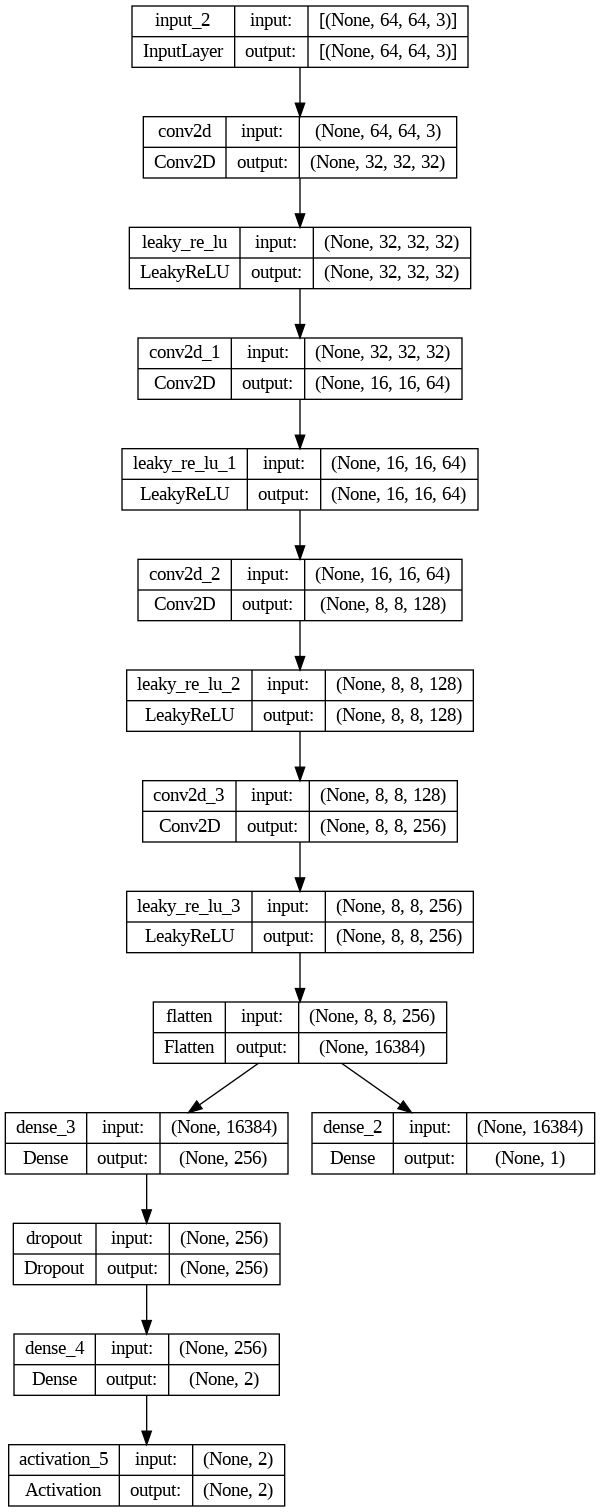

In [15]:
tf.keras.utils.plot_model(D, show_shapes = True)

Epoch: 0

discriminator loss: [tag: 0.5253190994262695, labels: 0.6905013918876648], generator loss: [tag: 0.26063966751098633, labels: 0.7032241821289062]

1/1 [==============================] - 0s 20ms/step


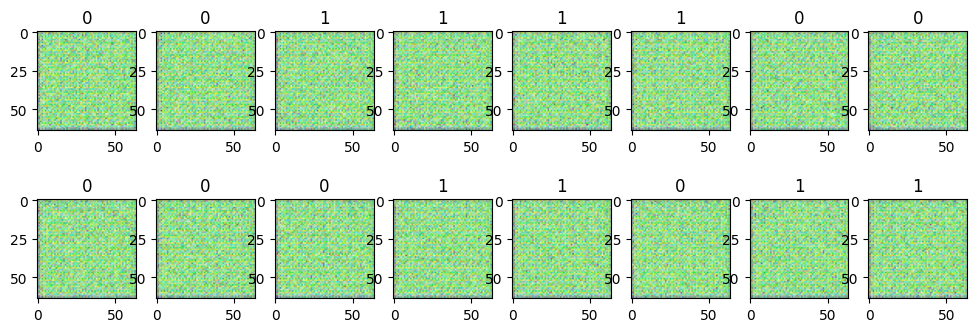

Epoch: 5000

discriminator loss: [tag: 0.2465503215789795, labels: 0.056896377354860306], generator loss: [tag: 0.248743936419487, labels: 0.009133875370025635]

1/1 [==============================] - 0s 19ms/step


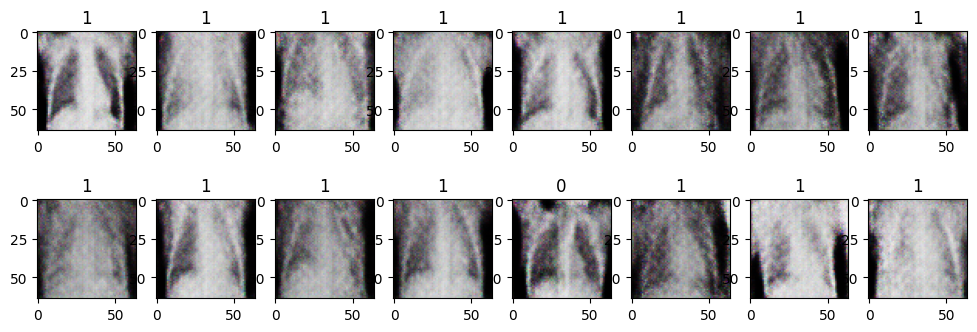

Epoch: 10000

discriminator loss: [tag: 0.19863693416118622, labels: 0.005140827037394047], generator loss: [tag: 0.3745771646499634, labels: 0.005375133361667395]

1/1 [==============================] - 0s 19ms/step


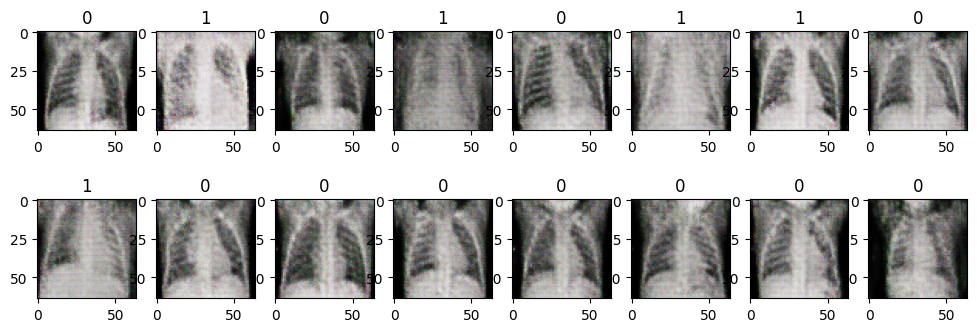

Epoch: 15000

discriminator loss: [tag: 0.2295529693365097, labels: 0.01235660444945097], generator loss: [tag: 0.25898462533950806, labels: 0.000474641565233469]

1/1 [==============================] - 0s 18ms/step


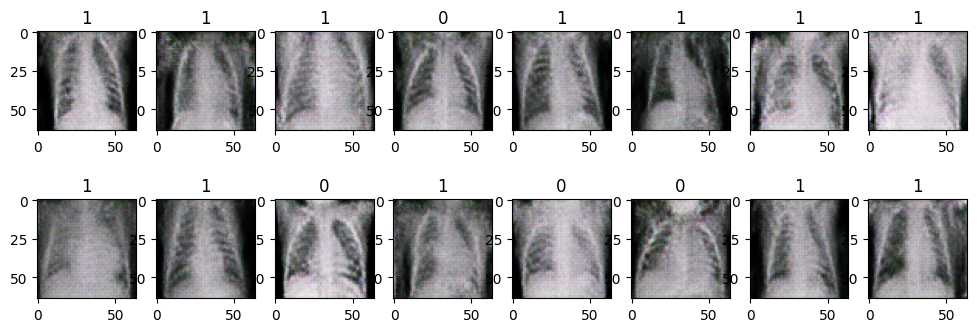

Epoch: 20000

discriminator loss: [tag: 0.23991727828979492, labels: 0.0036063287407159805], generator loss: [tag: 0.2855571210384369, labels: 0.009624933823943138]

1/1 [==============================] - 0s 18ms/step


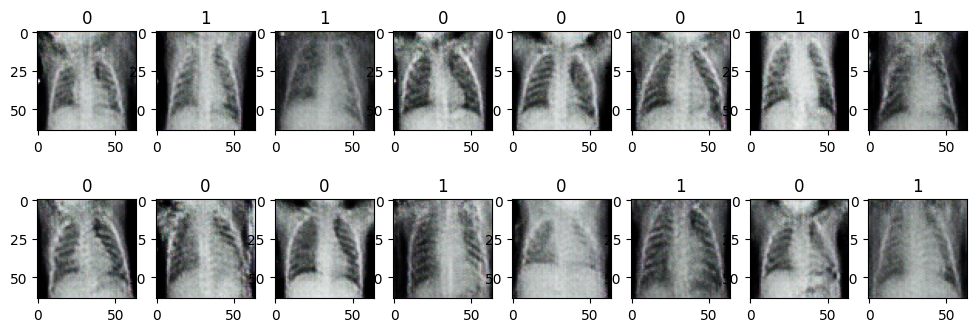

Epoch: 25000

discriminator loss: [tag: 0.20856669545173645, labels: 0.001940002548508346], generator loss: [tag: 0.4197908341884613, labels: 0.002672693459317088]

1/1 [==============================] - 0s 26ms/step


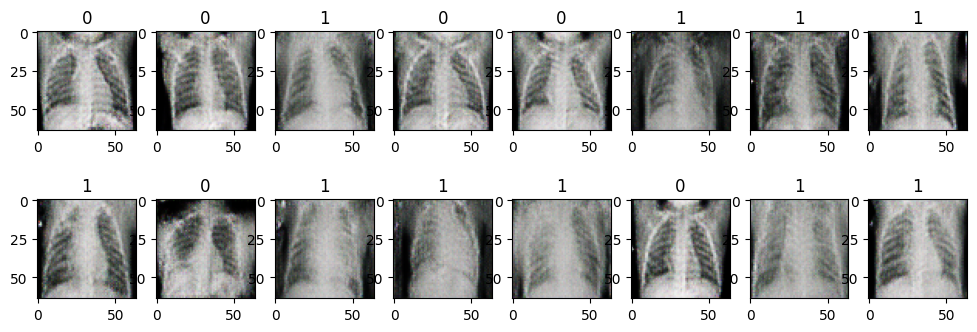

Epoch: 30000

discriminator loss: [tag: 0.24253657460212708, labels: 0.003363359486684203], generator loss: [tag: 0.23190180957317352, labels: 0.00012597988825291395]

1/1 [==============================] - 0s 18ms/step


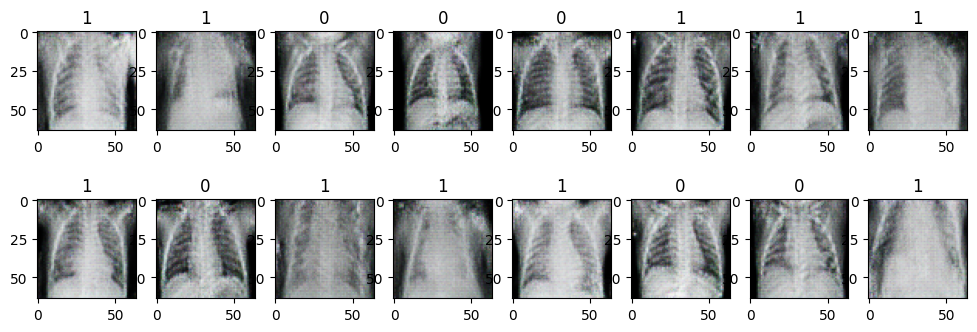

In [16]:
acgan.trainAlgorithm(G, D, GAN)

In [17]:
G.save('/kaggle/working/generator.h5')

In [5]:
G = tf.keras.models.load_model('/kaggle/working/generator.h5')

- We have to make sure that the images that the generator generates are correct, and that they actually include pathological conditions, and this is done by generating a large number of samples, using a neural network to classify the images, and then using the trained neural network, in order to classify the basic images that are included in the basic dataset.

In [6]:
datasetGenerationSize = 30000
noize = tf.random.uniform(shape = (datasetGenerationSize, 100), minval = -1, maxval = 1)
newlabels = tf.keras.utils.to_categorical(np.random.choice([0, 1], size = (datasetGenerationSize, )), num_classes = 2)

In [7]:
noize.shape, newlabels.shape

(TensorShape([30000, 100]), (30000, 2))

In [8]:
np.unique(np.argmax(newlabels, axis = 1), return_counts = True)

(array([0, 1]), array([14915, 15085]))

In [9]:
imagesGeneration = G.predict([noize, newlabels])
imagesGeneration.shape

938/938 [==============================] - 33s 26ms/step


(30000, 64, 64, 3)

- Samples generated by the generator for each case (healthy person, person with pneumonia).

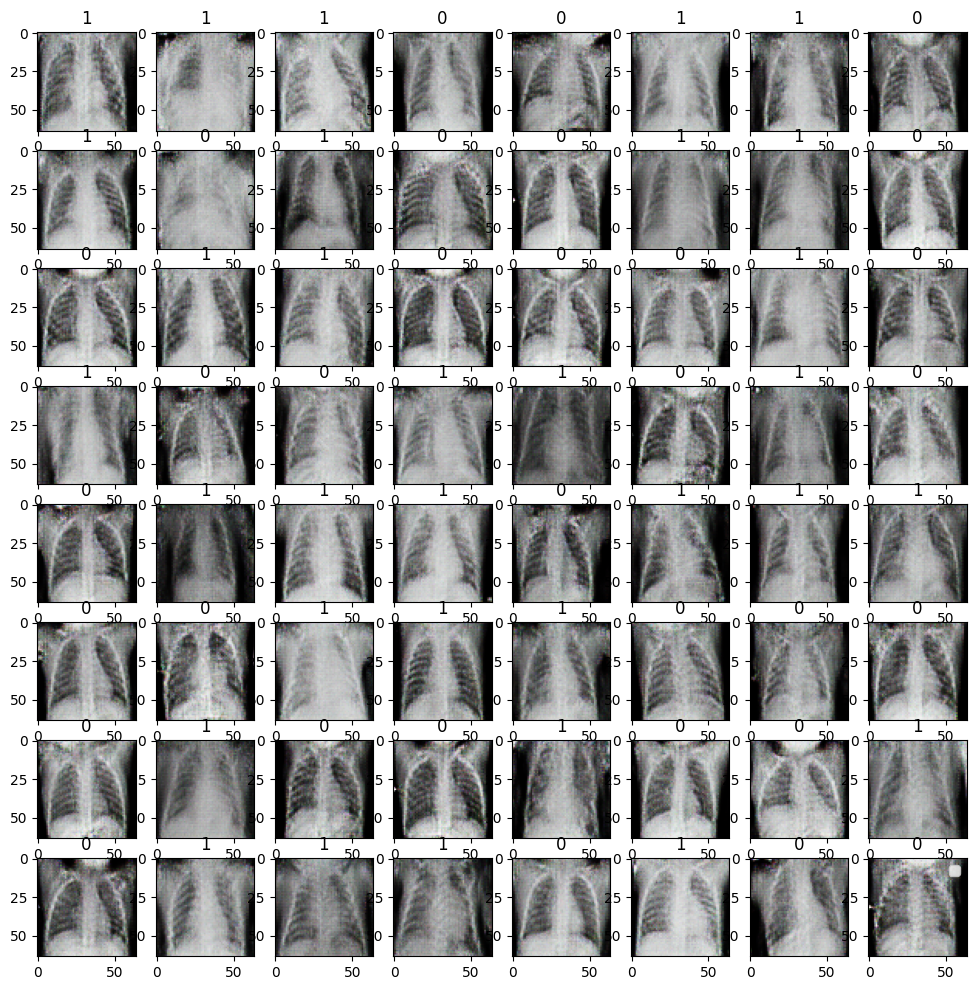

In [10]:
plt.figure(figsize = (12, 12))
t = np.argmax(newlabels, axis = 1)
for i in range(64):
    plt.subplot(8, 8, (i + 1))
    plt.imshow(imagesGeneration[i])
    plt.title(t[i])
plt.legend()

In order to be able to evaluate the images generated by the generating neural network, we can do so by proposing a neural structure dedicated to classifying the images generated by the generating neural network, and then we return to the basic images included in the dataset, and we evaluate the performance of the classified neural network that It was trained on the generated images, in order to see if the learned characteristics of the generated images can give high results on the basic images included in the dataset.

In [11]:
basemodel = tf.keras.applications.VGG16(weights = None, input_shape = (64, 64, 3),
                                        pooling = 'max', include_top = False)
x = layers.Dropout(0.4)(basemodel.output)
x = layers.Dense(128,)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha = 0.2)(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(32,)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha = 0.2)(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(1, activation = 'sigmoid')(x)
m = tf.keras.models.Model(inputs = basemodel.input, outputs = x)
m.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001))
m.summary()

Model: "model"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         

                                                                 

 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      

                                                                 

 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     

                                                                 

 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         

                                                                 

 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     

                                                                 

 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    

                                                                 

 block2_pool (MaxPooling2D)  (None, 16, 16, 1

In [12]:
history = m.fit(imagesGeneration, np.argmax(newlabels, axis = 1),
                epochs = 60, batch_size = 64,
                validation_split = 0.2,
                callbacks = [tf.keras.callbacks.EarlyStopping(patience = 2, monitor = 'val_loss', mode = 'min',
                                                              restore_best_weights = True)])

Epoch 1/60

375/375 [==============================] - 45s 89ms/step - loss: 0.2485 - val_loss: 0.5733

Epoch 2/60

375/375 [==============================] - 31s 83ms/step - loss: 0.0989 - val_loss: 0.1620

Epoch 3/60

375/375 [==============================] - 32s 85ms/step - loss: 0.0754 - val_loss: 0.0421

Epoch 4/60

375/375 [==============================] - 32s 85ms/step - loss: 0.0620 - val_loss: 0.0384

Epoch 5/60

375/375 [==============================] - 31s 84ms/step - loss: 0.0553 - val_loss: 0.0338

Epoch 6/60

375/375 [==============================] - 31s 83ms/step - loss: 0.0515 - val_loss: 0.0298

Epoch 7/60

375/375 [==============================] - 31s 83ms/step - loss: 0.0463 - val_loss: 0.0274

Epoch 8/60

375/375 [==============================] - 31s 83ms/step - loss: 0.0438 - val_loss: 0.0255

Epoch 9/60

375/375 [==============================] - 32s 84ms/step - loss: 0.0401 - val_loss: 0.0236

Epoch 10/60

375/375 [==============================] - 31s 83ms

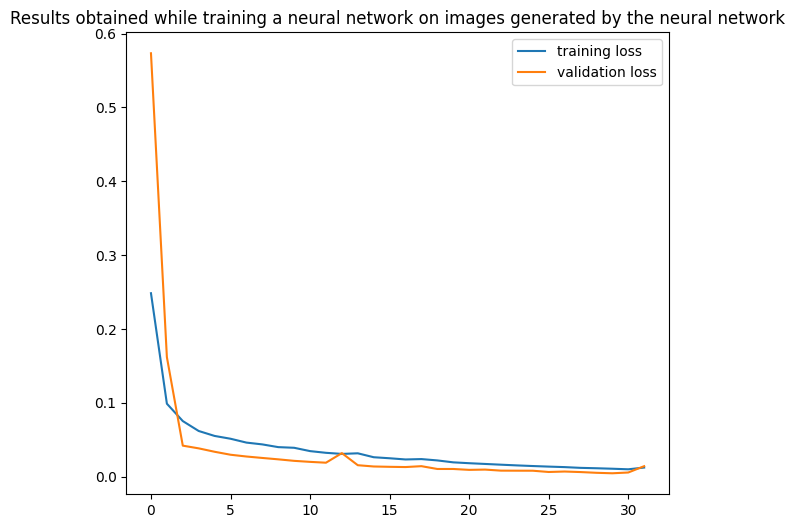

In [27]:
plt.figure(figsize = (7, 6))
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.title('Results obtained while training a neural network on images generated by the neural network')
plt.legend()

- Now, after training on the images generated by the generator, we will test the neural network on the basic images included in the dataset.

- We will use several measures in the evaluation to study what is the ability of the generative adversarial network to capture the basic features that characterize each class, and whether the second classified network extracted the features included in the generated images.
- Are the attributes that were extracted from the images generated by the generator, can be used on the original images included in the dataset.
- This helps in the ability to study what was actually generated, and whether the focus was really on the cases that the X-ray images made him have pneumonia or not.

In [14]:
m.evaluate(images, labels)

163/163 [==============================] - 3s 15ms/step - loss: 0.2774


0.27743175625801086

In [15]:
y_pred = tf.squeeze(m.predict(images))
y_pred.shape

163/163 [==============================] - 2s 14ms/step


TensorShape([5216])

In [16]:
y_pred = y_pred >= 0.5
y_pred = np.array(y_pred, dtype = 'int32')
y_pred

array([0, 0, 0, ..., 0, 1, 1], dtype=int32)

In [19]:
accuracy_score(y_pred, labels)*100

93.90337423312883

In [20]:
print(classification_report(y_pred, labels))

              precision    recall  f1-score   support



           0       0.98      0.82      0.89      1595

           1       0.93      0.99      0.96      3621



    accuracy                           0.94      5216

   macro avg       0.95      0.91      0.92      5216

weighted avg       0.94      0.94      0.94      5216




In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_pred, labels)
cm

array([[1309,  286],
       [  32, 3589]])

In [22]:
import pandas as pd
cmObject = pd.DataFrame(cm , index = ['NORMAL', 'PNEUMONIA'],
                        columns = ['NORMAL', 'PNEUMONIA'])
cmObject.head()

NORMAL  PNEUMONIA
NORMAL       1309        286
PNEUMONIA      32       3589

In [25]:
print('f1_score: {}, recall_score: {}, precision_score: {}'.format(f1_score(y_pred, labels)*100,
                                                                   recall_score(y_pred, labels)*100,
                                                                   precision_score(y_pred, labels)*100))

f1_score: 95.75773745997866, recall_score: 99.11626622479977, precision_score: 92.61935483870968


<Axes: >

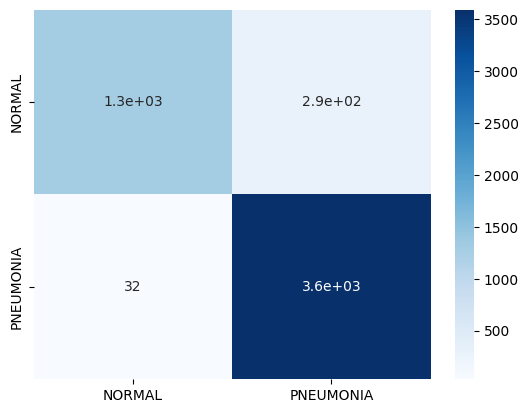

In [26]:
sns.heatmap(cmObject, annot = True, cmap="Blues")